# Kernels

**Author:** Himanshu Singhal

# Kernels
Here,we will be looking at the effects of different kernel functions on how they affect model performance and assumptions. As a setup, we will load some time-series data that we saw in class on modeling CO2 concentration:

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_context('notebook')

# # Fetch the data 
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

X, y = load_mauna_loa_atmospheric_co2()

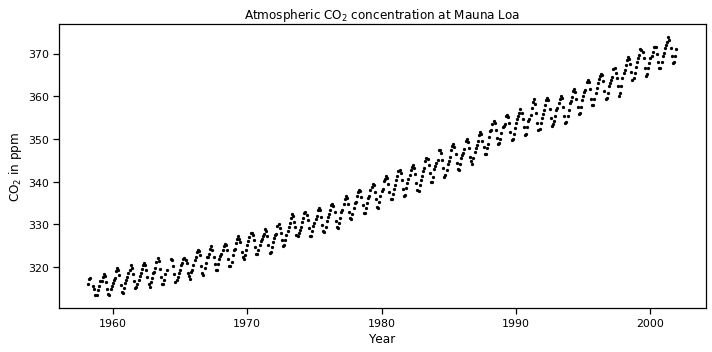

In [2]:
# Plot the data
plt.figure(figsize=(10,5))    # Initialize empty figure
plt.scatter(X, y, c='k',s=5) # Scatterplot of data
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

Then we will go ahead and load various [kernels available via Scikit Learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process). For example:

* [White Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html#sklearn.gaussian_process.kernels.WhiteKernel) for modeling noise
* [ExpSineSquared Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html#sklearn.gaussian_process.kernels.ExpSineSquared) for modeling periodic functions
* [RBF Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF) for smoothly varying functions
* [Matern Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern) for smoothly varying functions with controllable degrees of continuity in their derivatives
* [Constant Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html#sklearn.gaussian_process.kernels.ConstantKernel) for constant functions
* [Rational Quadratic kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic) for mixtures of RBF kernels with different length scales

With any of these kernels you can add them, multiply them, exponentiate them to create new, more complex kernels that embody multiple behaviors.

In [3]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel 
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic
from sklearn.gaussian_process.kernels import Sum, Product, Exponentiation
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct

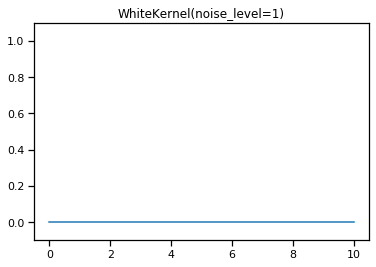

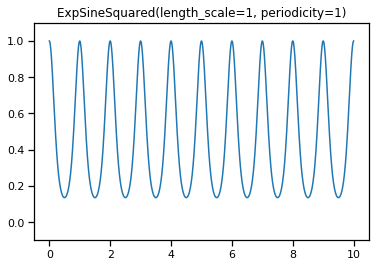

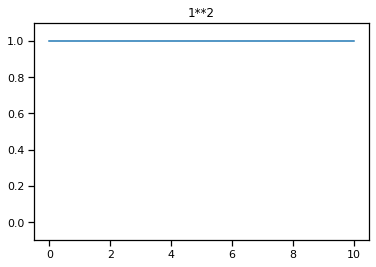

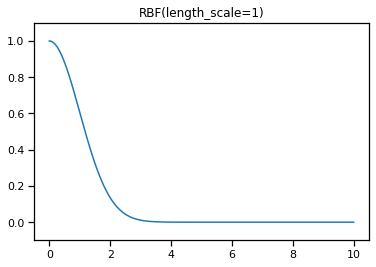

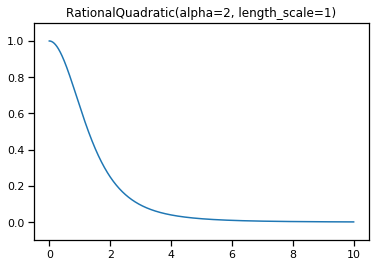

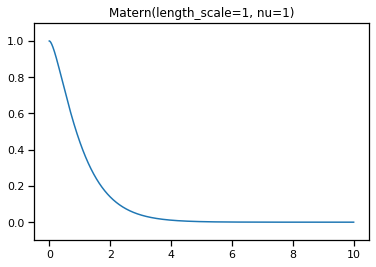

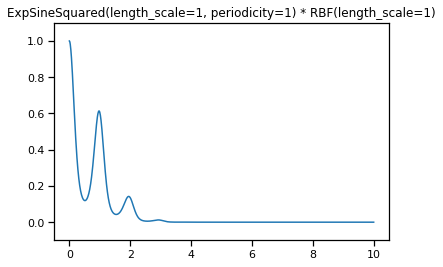

In [4]:
# Helper function that helps you visualize each of the different kernels
d = np.linspace(0,10,1000)
plot_kernel = lambda k,x: np.diag(k(np.array([[0]*len(x)]).T,x.reshape(len(x),1)))
kernels_to_plot=[
    WhiteKernel(noise_level=1),
    ExpSineSquared(length_scale=1, periodicity=1),
    ConstantKernel(constant_value=1),
    RBF(length_scale=1),
    RationalQuadratic(alpha=2, length_scale=1),
    Matern(nu=1, length_scale=1),
    # You can add your own here and also try combining them (add, mult, exp) etc.
    ExpSineSquared(length_scale=1, periodicity=1)*RBF(length_scale=1)
]
for kernel in kernels_to_plot:
    fig = plt.figure()
    plt.plot(d,plot_kernel(kernel,d))
    plt.title(str(kernel))
    plt.ylim([-0.1,1.1])
    plt.show()

## Task 1: Fitting Data with KRR
Take the CO2 data above and use Kernel Ridge Regression to fit the data.


In [8]:
# Helper code to perform the plotting for you
# You don't need to modify this cell
from textwrap import wrap
def plot_CO2_data(model,X,y,extrapolate=0,plot_var=False):
    # krr is a Kernel Ridge Regression object
    model.fit(X,y)
    
#     model.fit(X, y)

    # Predict using kernel ridge
    X_plot = np.linspace(X.min()-extrapolate, X.max()+extrapolate, 10000)[:, None]
    y_p = model.predict(X_plot)
    
    # Plotting
    plt.figure(figsize=(10,5))
    # Plot Original Data
    plt.scatter(X, y, s=10, marker='o', linewidths=1,
            edgecolors='k', facecolors='none',
           label='Data')
    plt.plot(X_plot,y_p,alpha=1,lw=2,label='Prediction')
    plt.fill_between(X_plot[:, 0], y_p, y_p,
             alpha=0.5, color='k')
    plt.xlim(X_plot.min(), X_plot.max())
    title_str = "\n".join(wrap(str(model.kernel), 60))
    title_str+='\n'+"$R^2$: {:.3f}".format(model.score(X,y))
    plt.title("Kernel: "+str(title_str))
    plt.xlabel("Year")
    plt.ylabel("$CO^2$")
    #plt.tight_layout()
    plt.legend()
    plt.show()

Specifically, your task will be to define different sets of kernels and see how their behavior changes the type of function that KRR predicts, as well as to try to capture various behaviors. Please construct kernels that embody functions with the following properties and use them within KRR to do prediction:


1. An infinitely differentiable/smooth function with a wide bandwidth/lengthscale
2. An infinitely differentiable/smooth function with a narrow bandwidth/lengthscale
3. A periodic function with period = 1
4. A periodic function with period = 1.5
5. A custom kernel of your own choice/design (can be a single kernel or combinations of them)

You can place these in the `kernels_to_plot` list below (like in the above example) and then use the plotting helper function below to plot the function:

In [9]:
## Add your choice of kernels to the below list:
kernels_to_plot = [
    #WhiteKernel(), # <- This is not a good kernel. This is just so the code runs out of the box.
    RBF(length_scale=10),
    RBF(length_scale=1),
    ExpSineSquared(length_scale=1, periodicity=1),
    ExpSineSquared(length_scale=1, periodicity=1.5),
    2.0*DotProduct(sigma_0=0.1) + ExpSineSquared(length_scale=1, periodicity=1.0)
]

In [10]:
# Printing out the "Help" function of KernelRidge so that you can see what parameters you can change
# Uncomment if you want to see various options for changing the KRR defaults
# help(KernelRidge)

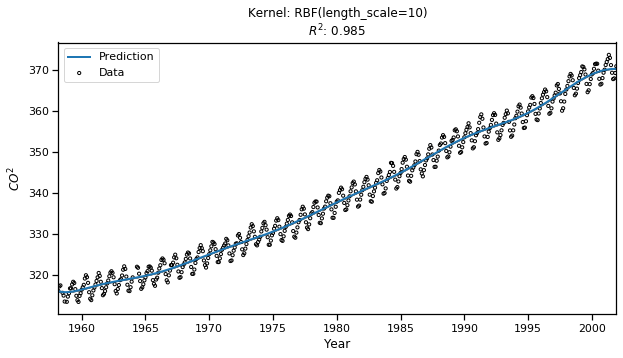

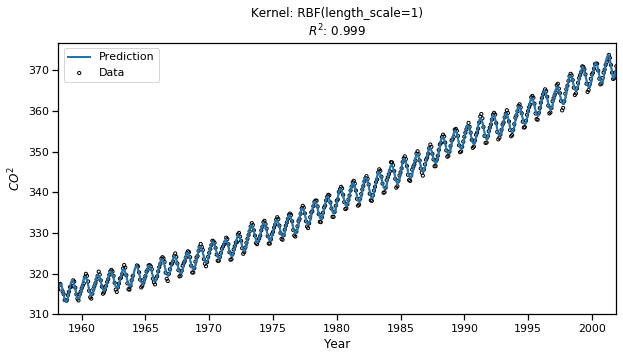

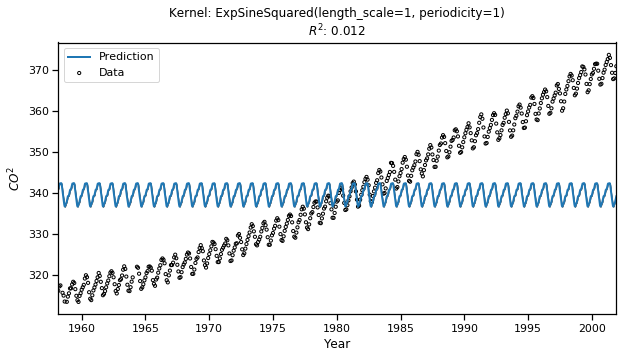

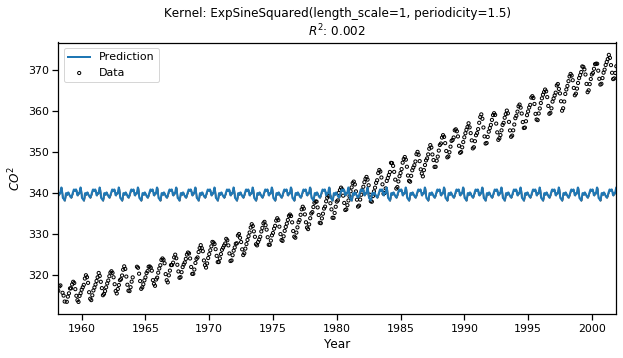

D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


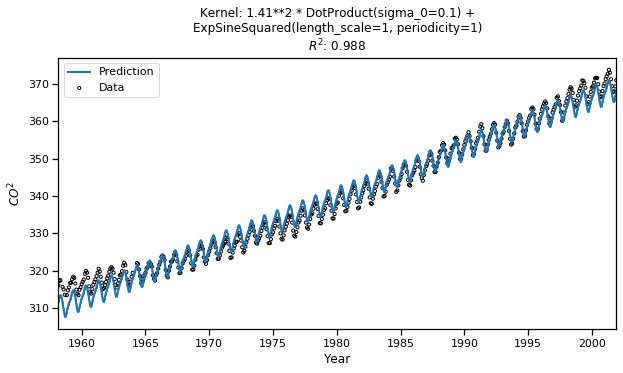

In [11]:
for kernel in kernels_to_plot:
    # Fit Kernel Ridge Regression using the kernels you identified above
    # You can change the default KRR settings below using the parameters listed
    # in the help function above, if you so desire.
    kr = KernelRidge(alpha = 1e-8,
                     kernel= kernel) 
    # Now extrapolate 30 years into the future and past:
    plot_CO2_data(kr,X,y,extrapolate=0)

## Task 2: Extrapolating KRR
Now repeat your analysis of the above, but where we extend the plotting to now cover not only the training data years, but also 30 years before and after the data:

In [12]:
## Add your choice of kernels to the below list:
kernels_to_plot_2 = [
    RBF(length_scale=10),
    RBF(length_scale=1),
    ExpSineSquared(length_scale=1, periodicity=1),
    ExpSineSquared(length_scale=1, periodicity=1.5),
    2.0*DotProduct(sigma_0=1.0)  +  ExpSineSquared(length_scale=1, periodicity=1.0)
]

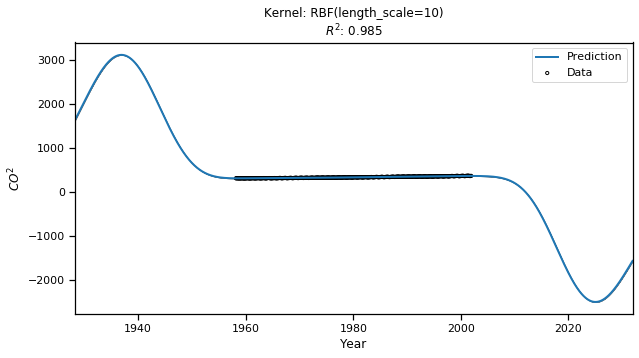

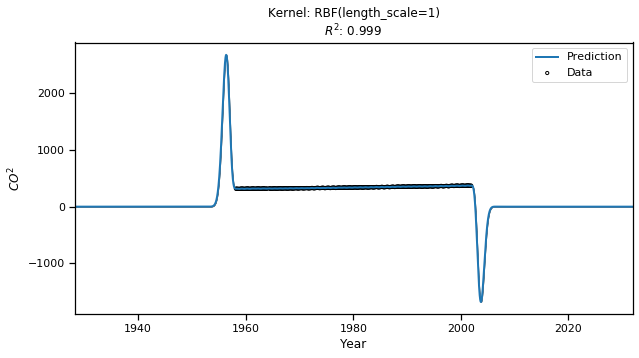

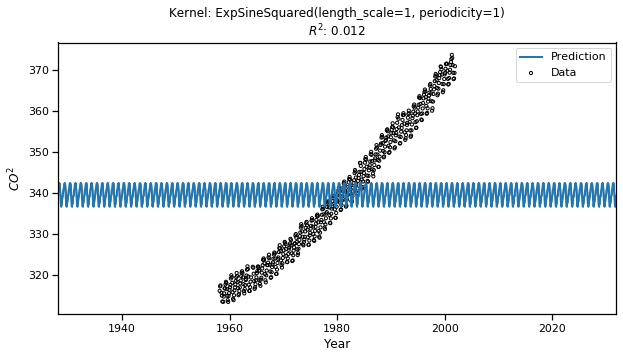

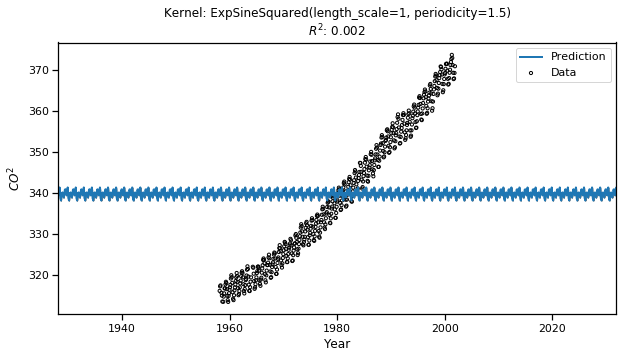

D:\Anaconda\lib\site-packages\sklearn\linear_model\ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


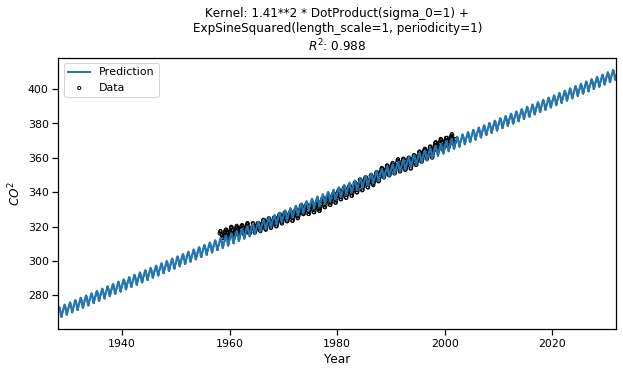

In [13]:
for kernel in kernels_to_plot_2:
    # Fit Kernel Ridge Regression using the kernels you identified above
    # You can change the default KRR settings below using the parameters listed
    # in the help function above, if you so desire.
    krr = KernelRidge(alpha=1e-8,kernel=kernel)
    # Now extrapolate 30 years into the future:
    plot_CO2_data(krr,X,y,extrapolate=30)

## Question 3:
Propose and construct and new kernel (either single or in combination) that fits both the above tasks.

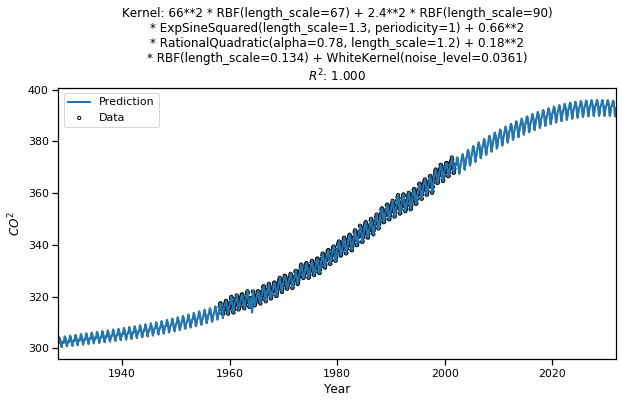

In [14]:
# Replace the below line with your own kernel
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel = k1 + k2 + k3 + k4
krr = KernelRidge(kernel=kernel, alpha=1e-8)
krr.fit(X, y)

X_ = np.linspace(X.min() - 30, X.max() + 30, 1000)[:, np.newaxis]
y_pred = krr.predict(X_)
plot_CO2_data(krr,X,y,extrapolate=30)